In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from os import walk
from tqdm import tqdm
import trimesh
import math
import json
import multiprocessing as mp

In [2]:
#%pip install scikit-image
from shapely.geometry import Polygon
from scipy.stats import moment
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.lines as mlines

In [3]:
'Example script for for the trimesh package.' \
'Documentation can be found on: https://trimsh.org/trimesh.html'

'Example script for for the trimesh package.Documentation can be found on: https://trimsh.org/trimesh.html'

In [4]:
def calc_Vol_Area_Centroid(path):
    'This method calculates the Volume and Surface area of a mesh'
    mesh = trimesh.load_mesh(path)
    V = mesh.volume
    A = mesh.area
    C = mesh.centroid
    return V, A, C

In [5]:
def check_mesh(path):
    'This method performs various checks - see trimesh documentation: https://trimsh.org/trimesh.html'
    mesh = trimesh.load_mesh(path)
    print('mesh is volume: %s' % mesh.is_volume)
    print('mesh is convex: %s' % mesh.is_convex)
    print('mesh is water tight: %s' % mesh.is_watertight)
    print('mesh is winding consistent: %s' % mesh.is_winding_consistent)
    if mesh.is_volume and mesh.is_convex and mesh.is_watertight and mesh.is_winding_consistent:
        print(path+' is a valid mesh')
        return True
    else:
        return False

In [6]:
def repair_mesh(path):
    'This method performs various mesh repair operations'
    mesh = trimesh.load(path)

    if not mesh.is_watertight:
        trimesh.repair.broken_faces(mesh, color=[255, 0, 0, 255])
        trimesh.repair.fix_inversion(mesh, multibody=True)
        trimesh.repair.fill_holes(mesh)
        trimesh.repair.fix_normals(mesh, multibody=True)

    mesh.show(smooth=False)

    print('mesh is volume: %s' % mesh.is_volume)
    print('mesh is convex: %s' % mesh.is_convex)
    print('mesh is water tight: %s' % mesh.is_watertight)
    print('mesh is winding consistent: %s' % mesh.is_winding_consistent)

In [7]:
def calc_angles(path):
    'This method loads a droplet mesh and calculates the contact angles around the perimeter of the contact line'
    mesh = trimesh.load(path)

    # #find minimal bounding cylinder and cut out slice from bottom to get vertices for CA determination
    # cyl_bounds = trimesh.bounds.minimum_cylinder(mesh, sample_count=6, angle_tol=0.001)
    # h = cyl_bounds["height"]
    # T = cyl_bounds["transform"]
    # print('bounding cylinder height: %s, transform: %s' %(h,T))

    plane_normal = (0,-1,0)
    plane_origin = (0,1.2,0)
    bottom_mesh = trimesh.intersections.slice_mesh_plane(mesh, plane_normal, plane_origin)

    plane_normal = (0, 1, 0)
    plane_origin = (0, 1.0, 0)
    middle_mesh = trimesh.intersections.slice_mesh_plane(bottom_mesh, plane_normal, plane_origin)

    verts = middle_mesh.vertices
    normals = middle_mesh.face_normals

    angles = []
    for n in normals:
        pair = np.stack((n, plane_normal), axis=1)
        pair = pair.T
        pair = np.expand_dims(pair, axis=0)
        angle = trimesh.geometry.vector_angle(pair)
        angles.append(angle)

    angles = np.squeeze(angles)
    elevation = angles * 180 / math.pi

    return elevation

In [8]:
def plot_method_of_calc_angles(path):
    mesh = trimesh.load(path)

    plane_normal = (0,-1,0)
    plane_origin = (0,1.2,0)
    bottom_mesh = trimesh.intersections.slice_mesh_plane(mesh, plane_normal, plane_origin)

    plane_normal = (0, 1, 0)
    plane_origin = (0, 1.0, 0)
    middle_mesh = trimesh.intersections.slice_mesh_plane(bottom_mesh, plane_normal, plane_origin)

    verts = middle_mesh.vertices
    normals = middle_mesh.face_normals
    fig=plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], mesh.vertices[:,2], triangles=mesh.faces)
    fig=plt.figure(figsize=(10,10))
    ax2 = fig.add_subplot(1, 1, 1, projection='3d')
    ax2.plot_trisurf(bottom_mesh.vertices[:, 0], bottom_mesh.vertices[:,1], bottom_mesh.vertices[:,2], triangles=bottom_mesh.faces)
    fig=plt.figure(figsize=(10,10))
    ax3 = fig.add_subplot(1, 1,1, projection='3d')
    ax3.plot_trisurf(middle_mesh.vertices[:, 0], middle_mesh.vertices[:,1], middle_mesh.vertices[:,2], triangles=middle_mesh.faces)
    plt.show()    

In [9]:
def get_bottom_sliced_area_scatter(path, plot = False):
    mesh = trimesh.load(path)
    isect, face_inds = trimesh.intersections.mesh_plane(
        mesh,
        plane_normal=(0,1,0),
        plane_origin=(0,1.0,0),
        return_faces=True
        )
    if plot:
        plt.scatter(*isect[:,0,0::2].T)
        plt.show()
    return isect[:,0,0::2]

In [10]:
# Sorts coordinates clockwise
# Only works if center is (0, 0)
def sort_clockwise(coords):
    # coords is a numpy array of shape (n, 2) where n is the number of coordinates
    angles = np.arctan2(coords[:, 0], coords[:, 1]) # calculate angles
    sorted_indices = np.argsort(angles) # sort indices by angles
    return coords[sorted_indices] # return sorted coordinates

In [11]:
# This function calculates the area of a polygon given its vertices based on the so-called
# Shoelace-Formula
# ! The coordinates must be sorted either in a clockwise - or counterclockwise manner.
def polygon_area(coords):
    # coords is a numpy array of shape (n, 2) where n is the number of vertices
    x = coords[:, 0]
    y = coords[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area

In [12]:
def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Define a function to calculate the circumference of a polygon
def circumference(coords):
    # coords is a numpy array of shape (2, n) where n is the number of vertices
    x = coords[0]
    y = coords[1]
    # Initialize the circumference to zero
    c = 0
    # Loop through the vertices of the polygon
    for i in range(len(x)):
        # Get the coordinates of the current and next vertex
        x1, y1 = x[i], y[i]
        x2, y2 = x[(i + 1) % len(x)], y[(i + 1) % len(y)]
        # Add the distance between them to the circumference
        c += distance(x1, y1, x2, y2)
    # Return the circumference
    return c

In [13]:
def get_props_of_biggest_circle(bottom_area_coordinates):
    radius=0
    center=[0,0]
    intersects=False
    while intersects is False:
        radius+=0.1
        for i in range(0,len(bottom_area_coordinates)):
            if (np.linalg.norm(bottom_area_coordinates[i]-center)<= radius):
                intersects=True
                radius-=0.1
                return center, radius
            
def get_a_to_circle_in_bottom_area(bottom_area_coordinates):
    center,radius=get_props_of_biggest_circle(bottom_area_coordinates)
   
    a=[]           
    for i in range(0,len(bottom_area_coordinates)):
            a.append((np.linalg.norm(bottom_area_coordinates[i]-center)-radius))
    return a

def get_w_of_a(a):
    return np.sqrt(1/len(a)*np.sum((a-np.mean(a))**2))

def get_a(path):
    mesh = trimesh.load(path)
    isect, face_inds = trimesh.intersections.mesh_plane(
        mesh,
        plane_normal=(0,1,0),
        plane_origin=(0,1.0,0),
        return_faces=True
        )
    bottom_area_coordinates=np.array(isect[:,0,0::2])
    radius=0
    center=[0,0]
    intersects=False
    while intersects is False:
        radius+=0.1
        for i in range(0,len(bottom_area_coordinates)):
            if (np.linalg.norm(bottom_area_coordinates[i]-center)<= radius):
                intersects=True
                radius-=0.1
                break
    a=[]           
    for i in range(0,len(bottom_area_coordinates)):
            a.append((np.linalg.norm(bottom_area_coordinates[i]-center)-radius))
    return np.array(a)

In [14]:
def get_root_mean_square_height(a):
    return np.sqrt(1/len(a)*np.sum(a**2))

def get_skewness(a):
    rmsh=get_root_mean_square_height(a)
    return 1/(len(a)*rmsh**3)*np.sum(a**3)
    
def get_kurtosis(a):
    rmsh=get_root_mean_square_height(a)
    return 1/(len(a)*rmsh**4)*np.sum(a**4)

def get_max_peak_height(a):
    mean=np.mean(a)
    sp=np.max(a)-mean
    return sp

def get_max_pit_height(a):
    mean=np.mean(a)
    sv=abs(np.min(a)-mean)
    return sv

In [15]:
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

In [16]:
def plot_data(V, A):
    'Simple plotting method'
    fig, ax = plt.subplots(2)
    fig.suptitle('Volume and Area')
    ax[0].plot(A)
    ax[0].set_title('Area')
    ax[1].plot(V, 'tab:orange')
    ax[1].set_title('Volume')
    plt.show()

In [17]:
#Creates a json file of a dataframe containing the below mentioned columns
def createJson(filename, name, volume, area, angle, centroid):
    # create dictionary
    dataDict = {}
    for i in range(len(name)):
        dataDict[name[i]] = [volume[i], area[i], angle[i], centroid[i][0], centroid[i][1], centroid[i][2]]

    # write to file
    with open(filename+'.json', 'w') as f:
        json.dump(dataDict, f)

    return dataDict

In [18]:
obj_path ='/pfs/work7/workspace/scratch/oy0026-DDE2_droplet/OBJ/'

filenames = []
for (dirpath, dirnames, file_name) in walk(obj_path):
    for dirname in dirnames:
        for (dirpath, dirnames, file_name) in walk(obj_path+dirname):
            filenames.append(os.path.join(obj_path,dirname+'/'+file_name[0]))
    break
filenames = sorted(filenames)

# Area and perimeter calculation

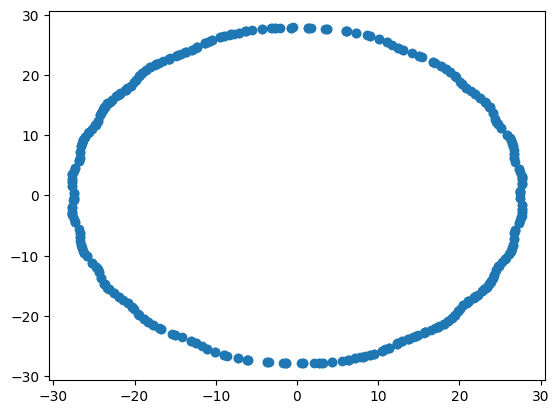

(462, 2)

In [19]:
coords = get_bottom_sliced_area_scatter(filenames[10], plot = True)
coords.shape

In [20]:
pgon = Polygon(coords)
print(pgon.area)
# Need to sort the coordinates in clockwise direction first:
sorted_coords = sort_clockwise(coords)
pgon_sorted = Polygon(sorted_coords)
print(pgon_sorted.area)

32.13801161987084
2419.8420010033433


In [21]:
print(polygon_area(sorted_coords))
print(circumference(sorted_coords))

2419.842001003348
75.02589488860626


In [22]:
# Rough Calculation:
avg_radius = np.average(np.sqrt(coords[:, 0]**2+coords[:, 1]**2))
print(f"Avg radius: {avg_radius}, resulting Area: {math.pi*avg_radius**2}, resulting circumference: {2 * math.pi *avg_radius}")

Avg radius: 27.75476278344369, resulting Area: 2420.0531953332033, resulting circumference: 174.3883177251882


# Elipse fit and aspect ratio

(462, 2)
slope of axes 2: -0.04514430571975612
center =  (-2.2673890739167874e-08, 8.613306027747565e-08)
angle of rotation =  87.41517682364477
axes =  (27.867960543366202, 27.663122958923335)
aspect ratio: 1.0074047165515994


/scratch/slurm_tmpdir/job_22467001/ipykernel_440905/3712762634.py:32: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')


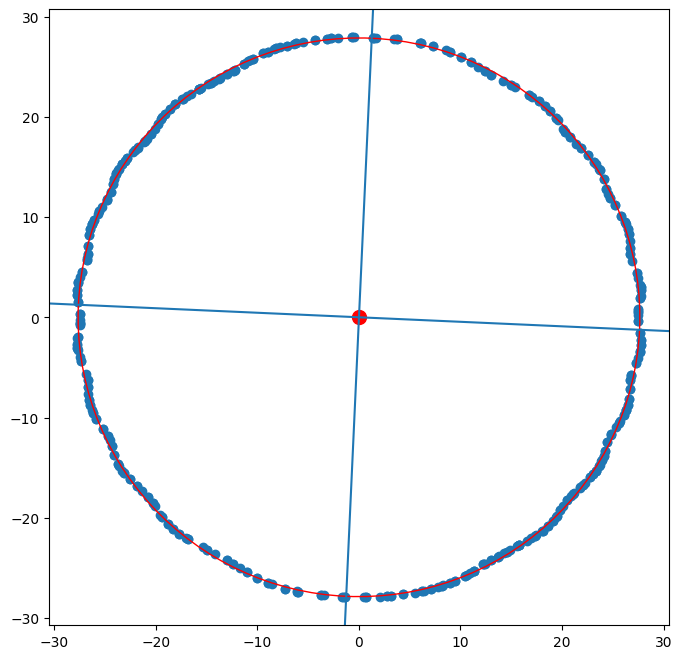

longest distance: 28.03199249246131
shortest distance: 27.411482480654566
second aspect ratio: 1.0226368643959576


In [23]:
x = coords[:, 0]
y = coords[:, 1]
print(np.shape(coords))

ell = EllipseModel()
ell.estimate(coords)

xc, yc, a, b, theta = ell.params

# calculate axes from angle
m1 = np.tan(theta)
m2 = np.tan(theta+np.pi/2)

line1 = [xc+1,yc+m1]
line2 = [xc+1,yc+m2]
print("slope of axes 2:",m2)

print("center = ",  (xc, yc))
print("angle of rotation = ",  theta*180/np.pi)
print("axes = ", (a,b))

aspectRatio = a/b
print("aspect ratio:",aspectRatio)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=[8,8])

axs.scatter(x, y)
axs.scatter(xc, yc, color='red', s=100)
# axs.set_xlim([-20,20])
# axs.set_ylim([-20,20])

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

newline([xc,yc],line1)
newline([xc,yc],line2)

axs.add_patch(ell_patch)
plt.show()


# calculate longest and shortest axes from point cloud and with that a second aspect ratio
distance = np.zeros(len(coords))
for i in range(len(distance)):
    distance[i] = np.sqrt(coords[i,0]**2+coords[i,1]**2)

a1 = np.max(distance)
a2 = np.min(distance)
print("longest distance:", a1)
print("shortest distance:", a2)

aspectRatio2 = a1/a2
print("second aspect ratio:",aspectRatio2)

# Roughness, skewness and kurtosis

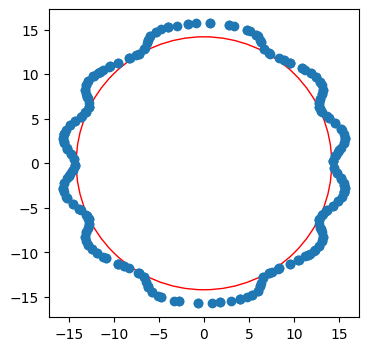

In [24]:
mesh = trimesh.load(os.path.join(obj_path, filenames[1]))
isect, face_inds = trimesh.intersections.mesh_plane(
    mesh,
    plane_normal=(0,1,0),
    plane_origin=(0,1.0,0),
    return_faces=True
    )
coordinates=np.array(isect[:,0,0::2])
center,radius=get_props_of_biggest_circle(coordinates)
circle=plt.Circle((center[0],center[1]),radius,color='r',fill=False)
fig, ax = plt.subplots(figsize=(4,4))
ax.add_patch(circle)
ax.scatter(*isect[:,0,0::2].T)
plt.show()

0.9555492172294339


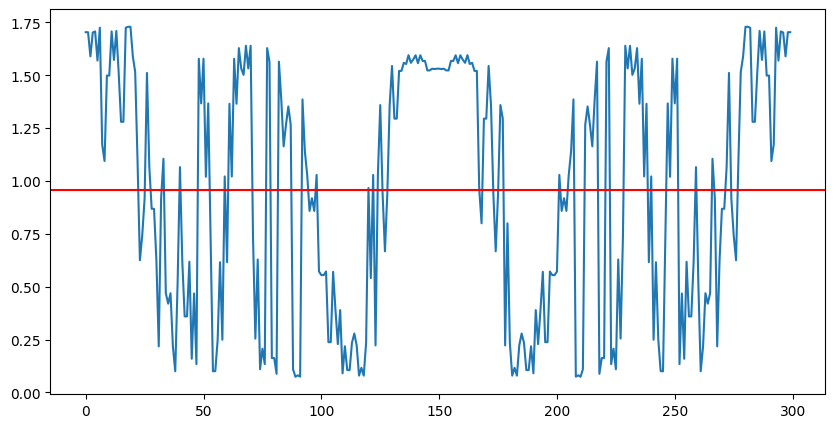

In [25]:
a=get_a_to_circle_in_bottom_area(coordinates)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(a)
plt.axhline(np.mean(a),color='r')
print(np.mean(a))

In [26]:
print(get_w_of_a(a))

0.5719713184379617


In [27]:
a=np.array(a)
print(get_skewness(a))
print(get_kurtosis(a))
print(get_max_peak_height(a))
print(get_max_pit_height(a))

1.2820452590699662
1.714389325514853
0.77397984467396
0.8812274032445052


# Central Moments

In [28]:
def return_moments (order = 2, plot = False):
    moments = []
    for filename in tqdm(filenames):
        coords = get_bottom_sliced_area_scatter(filename, plot = False)
        moments.append(moment(coords, moment = order))
    if plot:
        plt.plot(moments)
        plt.show()
    return moments

100%|██████████| 1479/1479 [17:10<00:00,  1.44it/s]


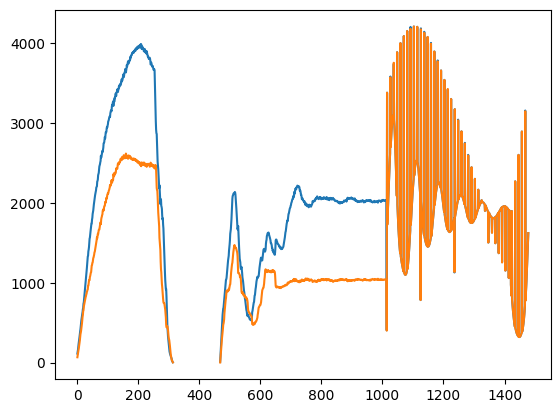

In [29]:
moments_2 = return_moments(order = 2, plot = True)

100%|██████████| 1479/1479 [16:39<00:00,  1.48it/s]


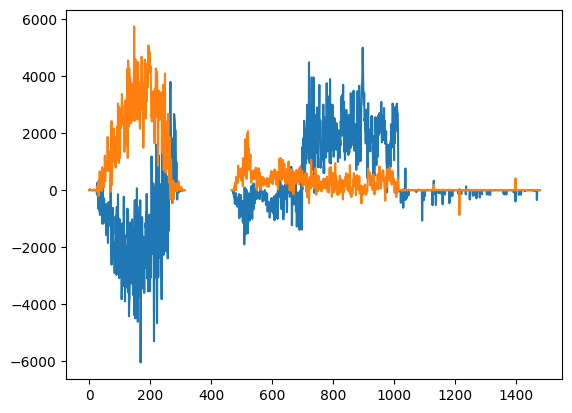

In [31]:
moments_3 = return_moments(order = 3, plot = True)

100%|██████████| 1479/1479 [16:18<00:00,  1.51it/s]


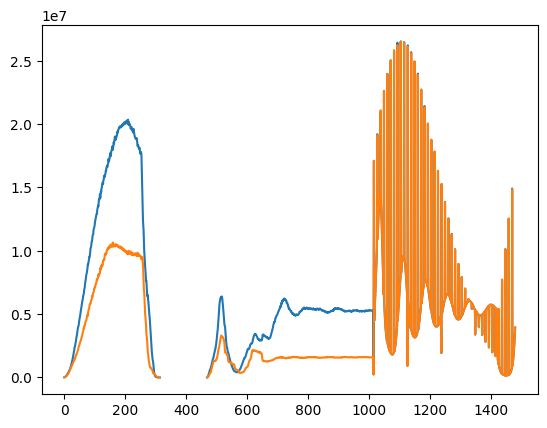

In [32]:
moments_4 = return_moments(order = 4, plot = True)

# Visualization of droplets

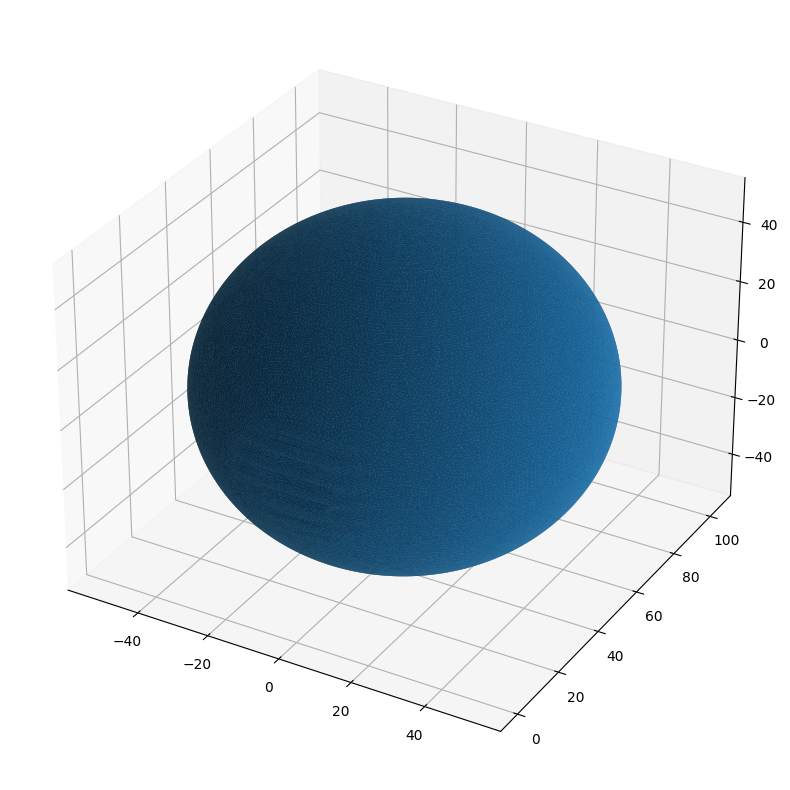

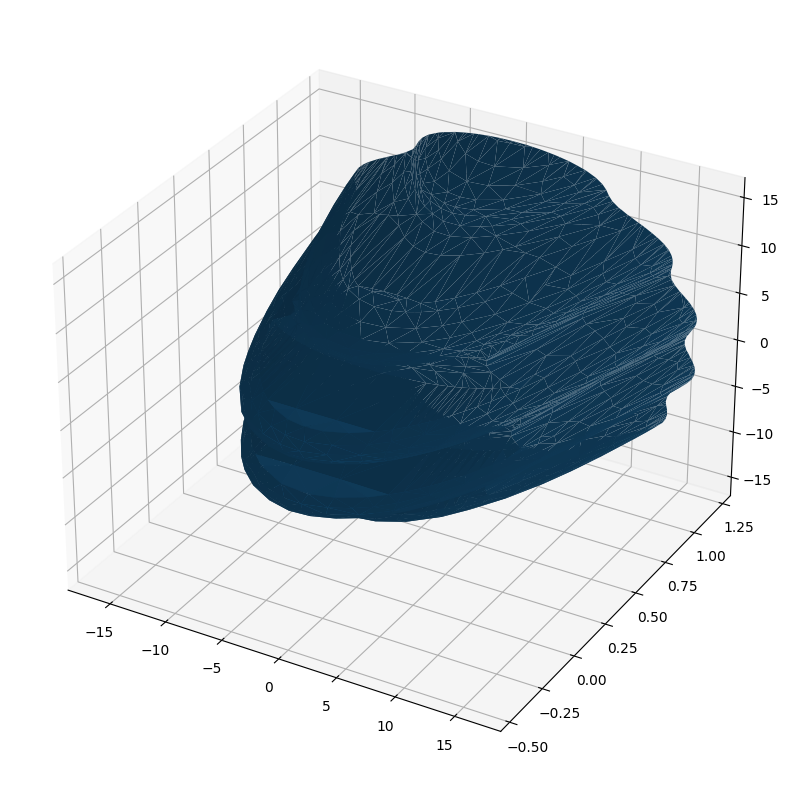

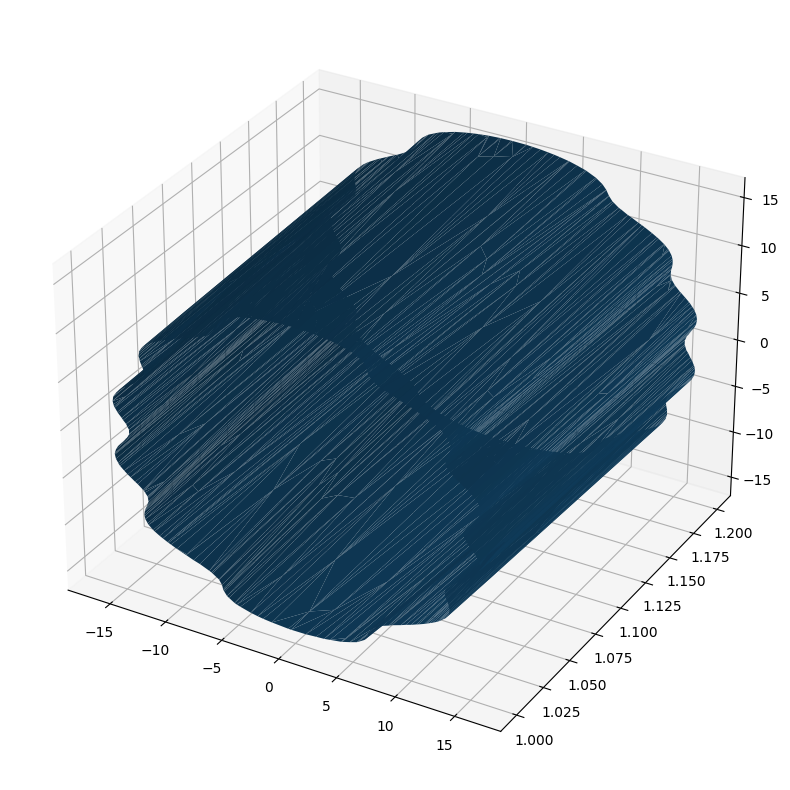

In [33]:
plot_method_of_calc_angles(filenames[1])